In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from src.preprocess import stratify5
from src.aggregate_features import generate_lrtt_features, generate_maf_features
from src.read_data import load_reference_data2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut, cross_val_score

#LOAD DATASETS
phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')
maf = pd.read_csv('./data/derived/imputed_MAF_data2.csv')
ambig = pd.read_csv('./data/derived/ambiguity/ambiguity_genes.csv')

#ADD TSI CATEGORIES
phylo = stratify5(phylo)
maf = stratify5(maf)

#sort by ID and coordinate
phylo = phylo.sort_values(by=['RENAME_ID', 'xcoord'])
maf = maf.sort_values(by=['RENAME_ID', 'Window_Centre'])

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_6367/1318073203.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')


In [20]:
features_binary = []

features_multiclass = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                        'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                        'genome_maf12c', 'gp120_ambig', 
                        'lrtt_coeff_1', 'lrtt_coeff_3']

feautures_regressor = []

features_tanya = ['gag_lrtt', 'gp120_lrtt', 'pol_lrtt',
                  'gp41_tips', 'gag_tips', 'gp120_tips',
                  'gp41_maf12c',
                  'gag_maf3c', 'gp41_maf3c']

# 1 - Prepare Data

In [21]:
#ENCODE STRATA IN FIVE CLASSES
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
phylo['TSI_encoded'] = ordinal_encoder.fit_transform(phylo[['TSI_category']])
maf['TSI_encoded'] = ordinal_encoder.fit_transform(maf[['TSI_category']])

#FIND UNIQUE IDS   
unique_ids = phylo['RENAME_ID'].unique()
#SPLIT BASED ON IDS
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

#TRAIN AND TEST DATASETS
train_phylo = phylo[phylo['RENAME_ID'].isin(train_ids)]
test_phylo = phylo[phylo['RENAME_ID'].isin(test_ids)]
train_maf = maf[maf['RENAME_ID'].isin(train_ids)]
test_maf = maf[maf['RENAME_ID'].isin(test_ids)]
train_ambig = ambig[ambig['RENAME_ID'].isin(train_ids)]
test_ambig = ambig[ambig['RENAME_ID'].isin(test_ids)]

# 2 - Plot Unsmoothed Data

In [3]:
def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    """Calculate the bootstrap 95% confidence interval."""
    bootstrapped_means = []
    n = len(data)
    
    for _ in range(num_bootstrap_samples):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_means.append(np.mean(sample))
    
    lower_bound = np.percentile(bootstrapped_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + confidence_level) / 2 * 100)
    
    return lower_bound, upper_bound

# Function to add credible intervals to the data
def add_credible_intervals(df, group_by_columns, value_column):
    results = []
    
    for name, group in df.groupby(group_by_columns):
        mean_value = group[value_column].mean()
        lower_bound, upper_bound = bootstrap_confidence_interval(group[value_column].values)
        results.append((*name, mean_value, lower_bound, upper_bound))
    
    columns = group_by_columns + ['mean', 'lower_bound', 'upper_bound']
    return pd.DataFrame(results, columns=columns)

# Add credible intervals to the data
phylo_with_intervals = add_credible_intervals(train_phylo, ['TSI_category', 'xcoord'], 'normalised.largest.rtt')
maf12_with_intervals = add_credible_intervals(train_maf, ['TSI_category', 'Window_Centre'], 'MAF12c_Mean')
maf3_with_intervals = add_credible_intervals(train_maf, ['TSI_category', 'Window_Centre'], 'MAF3c_Mean')

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_12025/222018577.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby(group_by_columns):


/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_12025/3785814175.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_phylo = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_12025/3785814175.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


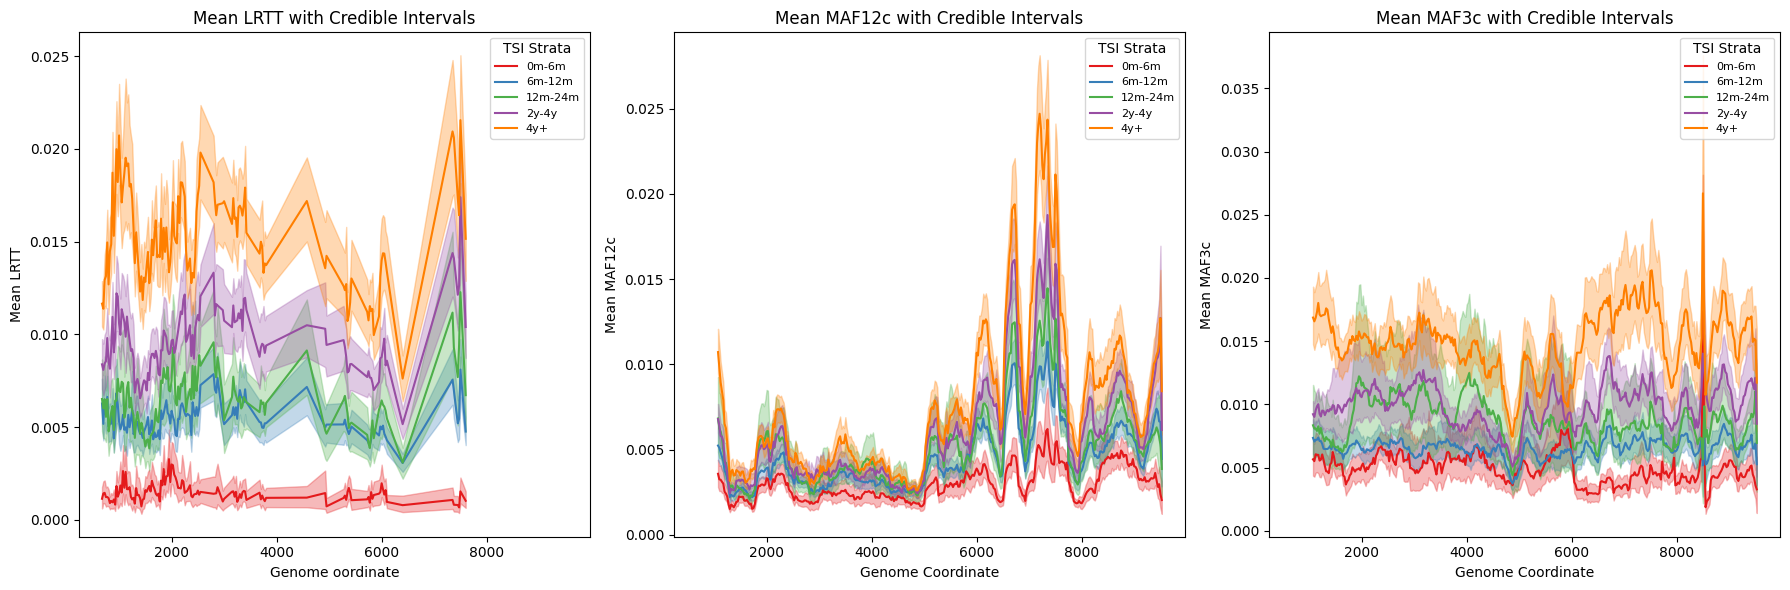

In [4]:
mean_values_phylo = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
}).reset_index()

# Calculate the mean values for each category and coordinate in train_maf
mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'MAF3c_Mean': 'mean',
}).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for normalised.largest.rtt
for i, category in enumerate(phylo_with_intervals['TSI_category'].unique()):
    category_df = phylo_with_intervals[phylo_with_intervals['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['mean'], '-', label=f'{category}', color=palette[i])
    axs[0].fill_between(category_df['xcoord'], category_df['lower_bound'], category_df['upper_bound'], color=palette[i], alpha=0.3)

axs[0].set_xlabel('Genome oordinate')
axs[0].set_ylabel('Mean LRTT')
axs[0].legend(title='TSI Strata', loc='upper right', fontsize=8)
axs[0].set_title('Mean LRTT with Credible Intervals')

# Plot for MAF12c_Mean
for i, category in enumerate(maf12_with_intervals['TSI_category'].unique()):
    category_df = maf12_with_intervals[maf12_with_intervals['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['mean'], '-', label=f'{category}', color=palette[i])
    axs[1].fill_between(category_df['Window_Centre'], category_df['lower_bound'], category_df['upper_bound'], color=palette[i], alpha=0.3)

axs[1].set_xlabel('Genome Coordinate')
axs[1].set_ylabel('Mean MAF12c')
axs[1].legend(title='TSI Strata', loc='upper right', fontsize=8)
axs[1].set_title('Mean MAF12c with Credible Intervals')

# Plot for MAF3c_Mean
for i, category in enumerate(maf3_with_intervals['TSI_category'].unique()):
    category_df = maf3_with_intervals[maf3_with_intervals['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['mean'], '-', label=f'{category}', color=palette[i])
    axs[2].fill_between(category_df['Window_Centre'], category_df['lower_bound'], category_df['upper_bound'], color=palette[i], alpha=0.3)

axs[2].set_xlabel('Genome Coordinate')
axs[2].set_ylabel('Mean MAF3c')
axs[2].legend(title='TSI Strata', loc='upper right', fontsize=8)
axs[2].set_title('Mean MAF3c with Credible Intervals')

plt.tight_layout()
plt.savefig('./outputs/unsmoothed/unsmoothed_features_across_genome.png')
plt.show()

# 3 - Aggregate Features

In [14]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

# Generate aggregated features for train and test datasets separately
train_phylo_features = generate_lrtt_features(train_phylo, gag, pol, gp120, gp41, feature='normalised.largest.rtt')
test_phylo_features = generate_lrtt_features(test_phylo, gag, pol, gp120, gp41, feature='normalised.largest.rtt')

train_maf_features = generate_maf_features(train_maf, gag, pol, gp120, gp41, feature_12c = 'MAF12c_Mean', feature_3c= 'MAF3c_Mean')
test_maf_features = generate_maf_features(test_maf, gag, pol, gp120, gp41, feature_12c = 'MAF12c_Mean', feature_3c= 'MAF3c_Mean')

# Merge the aggregated features
train_features = pd.merge(train_phylo_features, train_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
test_features = pd.merge(test_phylo_features, test_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')

In [15]:
# Merge ambiguity data
train_features = pd.merge(train_features, train_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')
test_features = pd.merge(test_features, test_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')

# Finalize the features
train_features = stratify5(train_features)
test_features = stratify5(test_features)

# 4 - Binary Classifier

## 4.1 'optimal' features

In [5]:
#DEFINE RECENCY
years = 1
recency_threshold = (years*12) * 30.44

features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig', 
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                    'gp41_maf12c', 'gp41_maf3c', 'gp41_ambig']

# Label the data
train_features['recency'] = np.where(train_features['TSI_days'] <= recency_threshold, 1, 0)
test_features['recency'] = np.where(test_features['TSI_days'] <= recency_threshold, 1, 0)

# Features and target variable for training and testing sets
X_train = train_features[features_derived]
y_train = train_features['recency']
X_test = test_features[features_derived]
y_test = test_features['recency']

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, accuracy_score

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        67
           1       0.77      0.81      0.79        88

    accuracy                           0.75       155
   macro avg       0.75      0.75      0.75       155
weighted avg       0.75      0.75      0.75       155


Additional Performance Metrics:
Accuracy: 0.7548
ROC AUC: 0.8487
Average Precision: 0.8843
Precision (Non-Recent): 0.7302
Recall (Non-Recent): 0.6866
F1-Score (Non-Recent): 0.7077
Precision (Recent): 0.7717
Recall (Recent): 0.8068
F1-Score (Recent): 0.7889


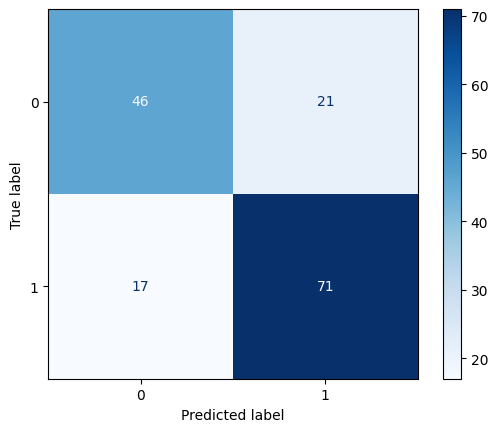

In [8]:
# Perform predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Calculate precision, recall, and f1-score for both classes
precision_non_recent = precision_score(y_test, y_pred, pos_label=0)
recall_non_recent = recall_score(y_test, y_pred, pos_label=0)
f1_non_recent = f1_score(y_test, y_pred, pos_label=0)

precision_recent = precision_score(y_test, y_pred, pos_label=1)
recall_recent = recall_score(y_test, y_pred, pos_label=1)
f1_recent = f1_score(y_test, y_pred, pos_label=1)

#PRINT RESULTS
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

print("\nAdditional Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Precision (Non-Recent): {precision_non_recent:.4f}")
print(f"Recall (Non-Recent): {recall_non_recent:.4f}")
print(f"F1-Score (Non-Recent): {f1_non_recent:.4f}")
print(f"Precision (Recent): {precision_recent:.4f}")
print(f"Recall (Recent): {recall_recent:.4f}")
print(f"F1-Score (Recent): {f1_recent:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## 4.2 - Tanyas Feautres

In [9]:
# Label the data
train_features['recency'] = np.where(train_features['TSI_days'] <= recency_threshold, 1, 0)
test_features['recency'] = np.where(test_features['TSI_days'] <= recency_threshold, 1, 0)

# Features and target variable for training and testing sets
X_train = train_features[features_tanya]
y_train = train_features['recency']
X_test = test_features[features_tanya]
y_test = test_features['recency']

NameError: name 'features_tanya' is not defined

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73        49
           1       0.88      0.87      0.87       106

    accuracy                           0.83       155
   macro avg       0.80      0.80      0.80       155
weighted avg       0.83      0.83      0.83       155



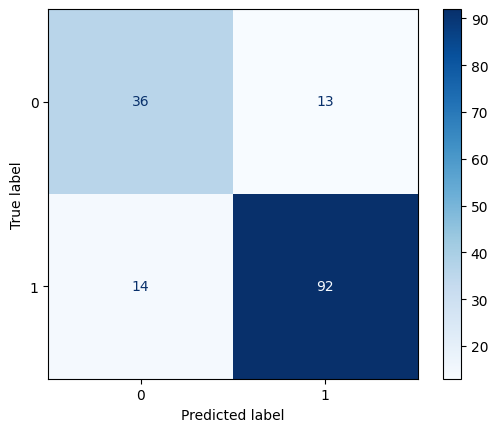

Accuracy: 0.8258064516129032


In [29]:
# Print results 
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))


# 5 - Multiclass Classifier

## 5.1 - 'optimal' features from smoothed recv

In [16]:
features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig',
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                    'gp41_maf12c', 'gp41_maf3c']
# DEFINE X AND Y 
X_train = train_features[features_derived]
y_train = train_features['TSI_category']
X_test = test_features[features_derived]
y_test = test_features['TSI_category']

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.43      0.67      0.52        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.33      0.35      0.34        20
         4y+       0.77      0.79      0.78        29
      6m-12m       0.58      0.61      0.60        64

    accuracy                           0.55       155
   macro avg       0.42      0.48      0.45       155
weighted avg       0.49      0.55      0.52       155



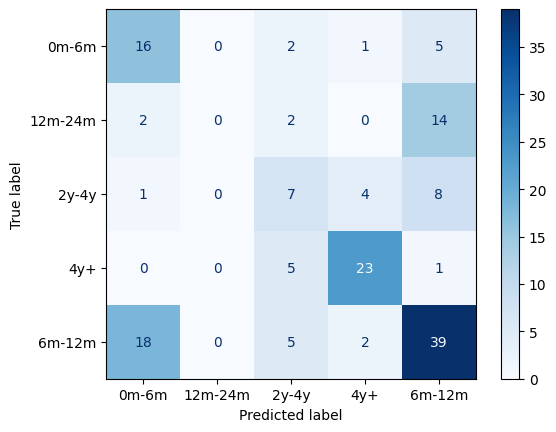

Accuracy: 0.5483870967741935
Balanced accuracy: 0.4838290229885057


In [20]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('./outputs/unsmoothed/confusion_matrix_2y.png')

plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))


## 5.2 Tanyas Features

In [23]:
# DEFINE X AND Y 
X_train = train_features[features_tanya]
y_train = train_features['TSI_category']
X_test = test_features[features_tanya]
y_test = test_features['TSI_category']

In [24]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.50      0.62      0.56        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.19      0.25      0.22        20
         4y+       0.75      0.72      0.74        29
      6m-12m       0.62      0.69      0.65        64

    accuracy                           0.55       155
   macro avg       0.41      0.46      0.43       155
weighted avg       0.50      0.55      0.52       155



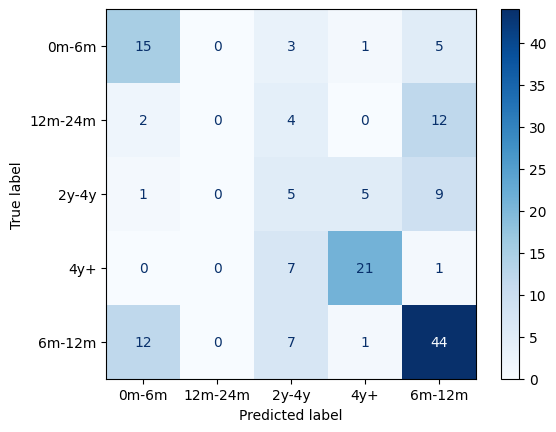

Accuracy: 0.5483870967741935
Balanced accuracy: 0.4573275862068965


In [25]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('./outputs/unsmoothed/confusion_matrix_tanya_2y.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

# 6 - Continuous Predictor - Sqrt

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, LeaveOneOut

In [23]:
# Convert TSI_days to TSI_years
train_features['TSI_years'] = train_features['TSI_days'] / 365
test_features['TSI_years'] = test_features['TSI_days'] / 365

# Transform TSI_years using the square root
train_features['sqrt_TSI_years'] = np.sqrt(train_features['TSI_years'])
test_features['sqrt_TSI_years'] = np.sqrt(test_features['TSI_years'])

X_train = train_features[features_tanya]
y_train = train_features['sqrt_TSI_years']
X_test = test_features[features_tanya]
y_test = test_features['sqrt_TSI_years']

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                param_grid=param_grid, 
                                cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

In [24]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 0.30254058302118253
Mean Absolute Error: 0.39988007310781437
Root Mean Squared Error: 0.5500368924183018
R-squared: 0.5823680237500224
